# Computation of $(S_b, \Delta_{dd})$, $(\Lambda_i, \delta_{ii})$ and $(\Lambda_i, \delta_{id})$ for different experiments

Go to [Index](response_Witz2019_index.ipynb).

In this notebook, we compute the correlations $(S_b, \Delta_{dd})$, $(\Lambda_i, \delta_{ii})$ and $(\Lambda_i, \delta_{id})$ for different data sets.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, re, copy
import numpy as np
import pandas as pd
import scipy.stats as sst
import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.gridspec as mgs
plt.rcParams['svg.fonttype'] = 'none'   # to export text as text, not curves
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('code')
from functions_response import get_binned

In [3]:
# create/declare export directory for figures
fig_dir = os.path.join('figures','standalone','correlation_comparison')
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
    
# experimental files
direxp = os.path.join('.','experiments')
    
# select extensions for the figure output
ext_list = ['.png','.svg']

## Global parameters

In [119]:
binw = 0.1  # bin size for binned average data
edges = 0.5 + np.arange(int(1./binw)+1)*binw -0.5*binw

fields = [ \
          ['Sb', 'Delta_bd'],
          ['Lambda_i', 'delta_id'],
          ['Lambda_i', 'delta_ii'],
          ['Lambda_i', 'tau_cyc']
         ]

## Load experimental data

In [127]:
dataframes = {}

### Analysis Witz et al

In [128]:
fpath_base = os.path.join(fig_dir,'witz')

names = [
         'glycerol', \
         'glucose', \
         'glucose8aa', \
         'glycerolauto' \
        ]

for name in names:
    fpath = os.path.join(direxp,name,'colidata.pkl')
    colidata = pd.read_pickle(fpath)

    colidata['lambda'] = colidata['lambda']*60
    ncells = len(colidata)
    print("ncells = {:d}".format(ncells))

    dataframes[name] = colidata

ncells = 865
ncells = 1094
ncells = 1251
ncells = 3018


### Analysis of Jun Lab data

#### MG

In [129]:
fpath_base = os.path.join(fig_dir,'mg')

names = [ \
         'mg1655_acetate', \
         'mg1655_glucose', \
         'mg1655_glycerol11aa', \
         'mg1655_acetate_uracil' , \
         'mg1655_glycerol6aa_uracil', \
         'mg1655_glucose_uracil', \
        ]

for name in names:
    fpath = os.path.join(direxp,name,'colidata.pkl')
    colidata = pd.read_pickle(fpath)

    colidata['lambda'] = colidata['lambda']*60
    ncells = len(colidata)
    print("ncells = {:d}".format(ncells))

    dataframes[name] = colidata
    

ncells = 1554
ncells = 1807
ncells = 1491
ncells = 219
ncells = 248
ncells = 328


#### NCM

In [130]:
fpath_base = os.path.join(fig_dir,'ncm')

names = [ \
         'ncm3722_arginine', \
         'ncm3722_glucose', \
         'ncm3722_glucose12aa', \
        ]

for name in names:
    fpath = os.path.join(direxp,name,'colidata.pkl')
    colidata = pd.read_pickle(fpath)

    colidata['lambda'] = colidata['lambda']*60
    ncells = len(colidata)
    print("ncells = {:d}".format(ncells))

    dataframes[name] = colidata
    

ncells = 1701
ncells = 1432
ncells = 1464


#### BW

In [131]:
fpath_base = os.path.join(fig_dir,'bw')

names = [ \
         'bw25113_glucose', \
         'bw25113_glucose_uracil', \
        ]

for name in names:
    fpath = os.path.join(direxp,name,'colidata.pkl')
    colidata = pd.read_pickle(fpath)

    colidata['lambda'] = colidata['lambda']*60
    ncells = len(colidata)
    print("ncells = {:d}".format(ncells))

    dataframes[name] = colidata

ncells = 499
ncells = 500


#### B. subtilis

In [132]:
fpath_base = os.path.join(fig_dir,'bsub')

names = [ \
         'jh642_mannose', \
         '3610_gly', \
         '3610_man', \
         '3610_suc' \
        ]

for name in names:
    fpath = os.path.join(direxp,name,'colidata.pkl')
    colidata = pd.read_pickle(fpath)

    colidata['lambda'] = colidata['lambda']*60
    ncells = len(colidata)
    print("ncells = {:d}".format(ncells))

    dataframes[name] = colidata
    

ncells = 623
ncells = 2355
ncells = 5478
ncells = 2530


## Compute the binned averages of the different correlations

In [133]:
elabels = ['mean', 'err', 'counts']

In [134]:
# for field_x, field_y in [['Lambda_i', 'delta_ii']]:
for field_x, field_y in fields:
    binned_mean = []
    binned_err = []
    binned_counts = []
    key_list = list(dataframes.keys())

    X_binned = edges[:-1].copy().round(6)
    for key in key_list:
        # get appropriate fields
        df = dataframes[key]
#         m_x, m_y = df.loc[:,[field_x, field_y]].mean(axis=0)
#         df_nrm = df.loc[:,[field_x, field_y]].apply(lambda x: x/np.array([m_x, m_y]), axis=1)
#         data = df_nrm.dropna().to_numpy().astype('float64')
        XY = df.loc[:, [field_x, field_y]].dropna().to_numpy().astype('float64')
        XY = XY / np.nanmean(XY, axis=0)
        X, Y = XY.T

        # bin data
        Y_binned_sets = get_binned(X, Y, edges)
        nbins = len(edges)-1
        Y_binned = np.zeros(nbins)*np.nan
        Y_binned_err = np.zeros(nbins)*np.nan
        Y_counts = np.zeros(nbins)*np.nan
        Y_vars = np.zeros(nbins)*np.nan

        for i in range(nbins):
            Yi = Y_binned_sets[i]
            Zi = np.sum(np.isfinite(Yi),axis=0)
            if (Zi == 0):
                continue
            m = np.nansum(Yi, axis=0) / Zi
            v = np.nansum((Yi-m)**2,axis=0) / Zi
            Y_counts[i] = Zi
            Y_binned[i] = m
            Y_vars[i] = v

    #     idx = np.isfinite(Y_counts) & (Y_counts > npts_bin_min)
        idx = np.isfinite(Y_counts)
        Y_binned[~idx] = np.nan
        Y_binned_err[idx] = np.sqrt(Y_vars[idx]/Y_counts[idx])

        # save mean and error on the mean
        binned_mean.append(Y_binned)
        binned_err.append(Y_binned_err)
        binned_counts.append(Y_counts)

    binned_mean = pd.DataFrame(data=np.array(binned_mean), index=key_list, columns=X_binned)
    binned_err = pd.DataFrame(data=np.array(binned_err), index=key_list, columns=X_binned)
    binned_counts = pd.DataFrame(data=np.array(binned_counts), index=key_list, columns=X_binned)
    
    # write files
    label = "{:s}_{:s}".format(field_x, field_y)
    
    for elabel, edf in zip(elabels, [binned_mean, binned_err, binned_counts]):
        edir = os.path.join(fig_dir, elabel)
        if not os.path.isdir(edir):
            os.makedirs(edir)
        
        efile = os.path.join(edir, '{:s}.csv'.format(label))
        edf.to_csv(efile)
        print(f"Written file {efile}.")

Written file figures/standalone/correlation_comparison/mean/Sb_Delta_bd.csv.
Written file figures/standalone/correlation_comparison/err/Sb_Delta_bd.csv.
Written file figures/standalone/correlation_comparison/counts/Sb_Delta_bd.csv.
Written file figures/standalone/correlation_comparison/mean/Lambda_i_delta_id.csv.
Written file figures/standalone/correlation_comparison/err/Lambda_i_delta_id.csv.
Written file figures/standalone/correlation_comparison/counts/Lambda_i_delta_id.csv.
Written file figures/standalone/correlation_comparison/mean/Lambda_i_delta_ii.csv.
Written file figures/standalone/correlation_comparison/err/Lambda_i_delta_ii.csv.
Written file figures/standalone/correlation_comparison/counts/Lambda_i_delta_ii.csv.
Written file figures/standalone/correlation_comparison/mean/Lambda_i_tau_cyc.csv.
Written file figures/standalone/correlation_comparison/err/Lambda_i_tau_cyc.csv.
Written file figures/standalone/correlation_comparison/counts/Lambda_i_tau_cyc.csv.


## Makes plots

In [135]:
npts_bin_min = 10

Sb Delta_bd
Lambda_i delta_id
Lambda_i delta_ii
Lambda_i tau_cyc


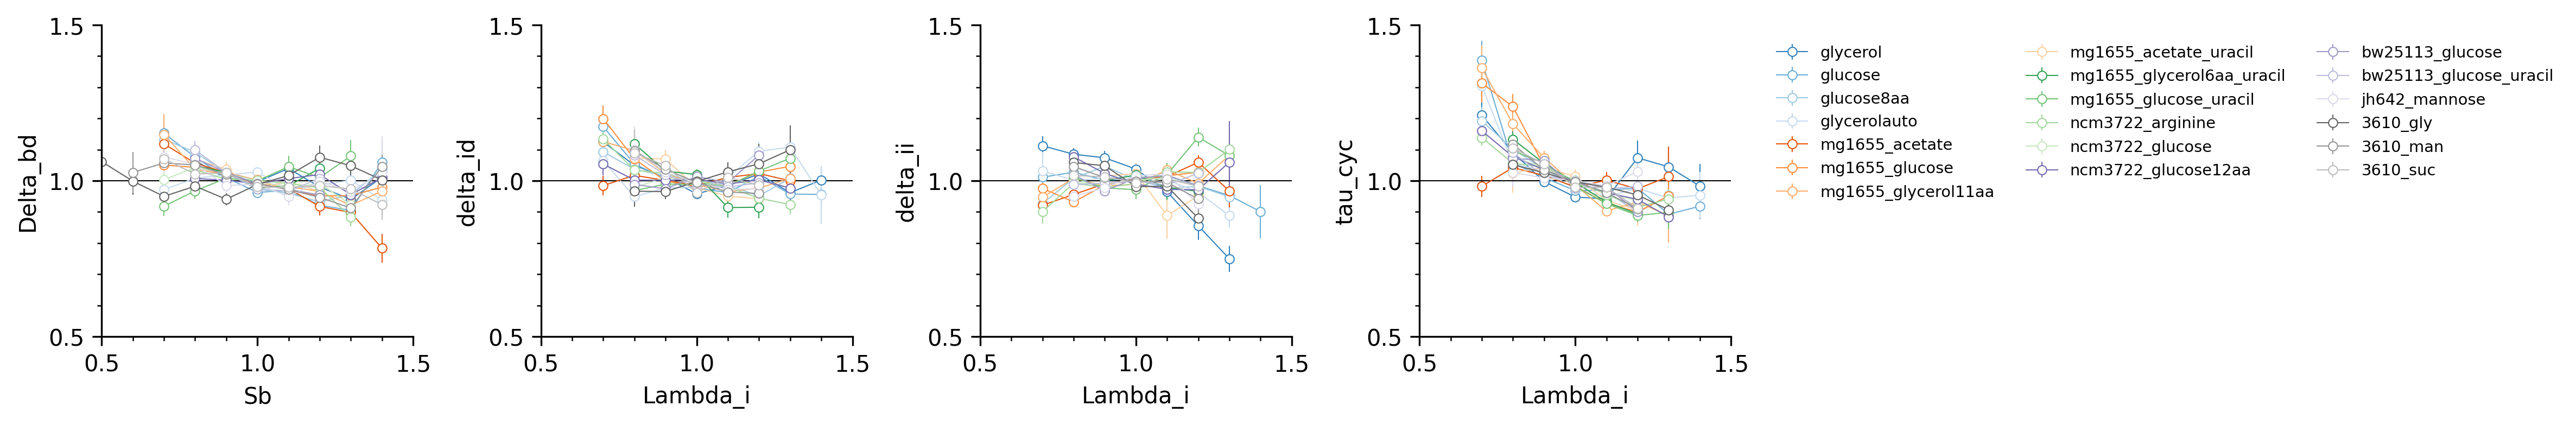

In [163]:
ncol=len(fields)
# cmap = cm.tab20
# cmap = cm.tab20b
cmap = cm.tab20c
fig = plt.figure(facecolor='w', figsize=(16,4), dpi=300)
gs = mgs.GridSpec(1, ncol)
# for i in range(1,ncol-1):
for i in range(ncol):
    ax = fig.add_subplot(gs[0,i])
    field_x, field_y = fields[i]
    print(field_x, field_y)
    label = "{:s}_{:s}".format(field_x, field_y)
    
    dfs = []
    for elabel in elabels:
        edir = os.path.join(fig_dir, elabel)
        efile = os.path.join(edir, '{:s}.csv'.format(label))
        df = pd.read_csv(efile, index_col=0)
        df.rename(columns={key: float(key) for key in df.columns}, inplace=True)
        dfs.append(df)
    
    df_mean = dfs[0]
    df_err = dfs[1]
    df_bool = dfs[2] >= npts_bin_min
    
    X = df_mean.columns.to_numpy()
    dx = np.diff(X)[0]
    X = X + 0.5*dx
    for j,name in enumerate(df_mean.index.tolist()):
        color = cmap(j)
        Y = df_mean.loc[name].to_numpy()
        Yerr = df_err.loc[name].to_numpy()
        idx = df_bool.loc[name].to_numpy()
        
        ax.errorbar(X[idx], Y[idx], Yerr[idx], elinewidth=0.5, ms=4, lw=0.5, mew=0.5, marker='o', mfc=
                    'w', color=color, mec=color, label=name)
        
    # plot horizontal line
    Xfit = [0.5, 1.5]
    Yfit = [1., 1.]
    ax.plot(Xfit, Yfit, 'k-', lw=0.5)
    
    # plot formatting
    ax.set_xlabel(field_x, fontsize='medium')
    ax.set_ylabel(field_y, fontsize='medium')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(bottom=True, left=True, labelbottom=True, labelleft=True)
    ax.tick_params(length=4)
    ax.set_xlim(0.5, 1.5)
    ax.set_ylim(0.5, 1.5)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.set_aspect('equal')
        
ax.legend(loc='upper left', fontsize='x-small', bbox_to_anchor=(1.1, 0.98), frameon=False, ncol=3)
    
gs.tight_layout(fig, rect=[0.,0.,1.,0.98])
plt.show()